# Digital Method Code

In [171]:
#import modules
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import tweepy
import jsonpickle
from collections import defaultdict

## Automated Network

### Import and clean data

In [149]:
#import dataset 
df_climate_final = pd.read_csv('df_climate_final.csv')

In [150]:
#previous dataset to extract mentions from
df_climate_both = pd.read_csv('df_climate.csv')

In [151]:
#clean data
df_climate_both.reset_index(inplace=True)
df_climate_both.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)

In [152]:
#convert tweet id to string
df_climate_both['tweet_id']=df_climate_both['tweet_id'].astype(str)

In [153]:
#no mentions in this new dataset, so create new column automated id - where the id is added only if present in the previous dataset used for networks 
df_climate_final.tweet_id=df_climate_final.tweet_id.astype(str)

df_climate_both['automated_id']= np.where(df_climate_both.tweet_id.str.contains('|'.join(df_climate_final.tweet_id)),1,0)

In [154]:
#new data for automated that contains tweet id that was in the final climate dataset
df_climate_both = df_climate_both[df_climate_both['automated_id'] == 1]
len(df_climate_both)

11596

In [155]:
#dataset before sorting mentions
df_climate_both

,name,screen_name,id_str,created_at,tweet_id,full_text,is_retweet,tweet_txt,mentions,hashtags,climate,tweets_preprocessed,democrate_wing,automated_id
0,Bernie Sanders,BernieSanders,216776631,Wed Nov 17 17:53:52 +0000 2010,1389681990689968130,The debate now with the Republican Party is no...,False,The debate now with the Republican Party is no...,[],[],1,debate republican party health care education ...,progressive,1
2,Bernie Sanders,BernieSanders,216776631,Wed Nov 17 17:53:52 +0000 2010,1388944407009841157,Our vision is that the government should repre...,False,Our vision is that the government should repre...,[],['BernieInKY'],1,vision government represent people foundation ...,progressive,1
4,Bernie Sanders,BernieSanders,216776631,Wed Nov 17 17:53:52 +0000 2010,1386488790487863297,Let's bring the world together and take on the...,False,Let's bring the world together and take on the...,[],[],1,let bring world together take existential thre...,progressive,1
7,Bernie Sanders,BernieSanders,216776631,Wed Nov 17 17:53:52 +0000 2010,1385320942839214081,Our grandchildren will ask us what we did to s...,False,Our grandchildren will ask us what we did to s...,[],[],1,grandchild ask u stop climate crisis answer,progressive,1
14,Bernie Sanders,BernieSanders,216776631,Wed Nov 17 17:53:52 +0000 2010,1372276555301363712,"I stand with nurses in Madison, Wisconsin who ...",False,"I stand with nurses in Madison, Wisconsin who ...",[],[],1,stand nurse madison wisconsin demand safe work...,progressive,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18431,Rep. Susan Wild,RepSusanWild,1069636653353000962,Mon Dec 03 16:57:05 +0000 2018,1090343074545500161,"I picked the subcommittee on Europe, Eurasia, ...",False,"I picked the subcommittee on Europe, Eurasia, ...",[],['PA07'],1,pick subcommittee europe eurasia energy amp en...,moderate,1
18432,Rep. Susan Wild,RepSusanWild,1069636653353000962,Mon Dec 03 16:57:05 +0000 2018,1075501050377973771,I was happy to meet with this distinguished gr...,False,I was happy to meet with this distinguished gr...,[],[],1,happy meet distinguish group scientist distric...,moderate,1
18433,Rep. Susan Wild,RepSusanWild,1069636653353000962,Mon Dec 03 16:57:05 +0000 2018,1075394985346904064,I'm proud that Pennsylvania is taking steps to...,False,I'm proud that Pennsylvania is taking steps to...,[],[],1,im proud pennsylvania take step develop clean ...,moderate,1
18434,Rep. Susan Wild,RepSusanWild,1069636653353000962,Mon Dec 03 16:57:05 +0000 2018,1072915083955707904,Today is the 3rd anniversary of the #ParisAgre...,False,Today is the 3rd anniversary of the #ParisAgre...,[],"['ParisAgreement', 'ActOnClimate']",1,today rd anniversary parisagreement next gener...,moderate,1


### Explode and sort mentions

In [118]:
#Since the data is in a weird format where they look like a list but really is a long string we need to clean it

#First split each string on ', '
df_climate_both['mentions'] = df_climate_both['mentions'].str.split(', ')

#Then go through each item per row and strip unwanted characters
for index, row in df_climate_both.iterrows():
    tmp = []
    for x in row['mentions']:
        x = x.strip()
        x = x.replace('[', '')
        x = x.replace(']', '')
        x = x[1:-1]
        tmp.append(x)
    df_climate_both.at[index, 'mentions'] = tmp

In [121]:
#to get each mention seperate on another row for network
df_climate_both = df_climate_both.explode('mentions', ignore_index=True)

In [135]:
#combined userlists for network
userlist = ['@BernieSanders', '@RepRaulGrijalva' , '@RepRubenGallego', '@RepHuffman', '@RepEBJ', '@RepLloydDoggett', '@PeterWelch', '@RepGwenMoore',
            '@RepDeSaulnier','@RepBarbaraLee', '@RoKhanna', '@RepZoeLofgren', '@RepDonBeyer', '@RepJayapal', '@RepAdamSmith', '@repmarkpocan',
            '@RepJimmyPanetta', '@RepJudyChu', '@BradSherman', '@gracenapolitano', '@tedlieu', '@RepJimmyGomez', '@RepKarenBass',
           '@RepLindaSanchez', '@RepMarkTakano', '@RepMaxineWaters', '@RepBarragan', '@RepKatiePorter', '@RepLowenthal', '@MikeLevin',
           '@RepJuanVargas', '@RepDianaDeGette', '@RepJoeNeguse', '@rosadelauro', '@RepLBR', '@RepDarrenSoto', '@RepLoisFrankel', '@EleanorNorton',
           '@RepWilson', '@RepHankJohnson', '@NikemaWilliams', '@kaikahele', '@RepMarieNewman', '@RepChuyGarcia', '@janschakowsky',
           '@RepAndreCarson', '@RepJohnYarmuth', '@chelliepingree', '@RepRaskin', '@RepMcGovern', '@RepLoriTrahan', '@RepKClark', '@RepDanKildee',
            '@AyannaPresley', '@RepDanKildee', '@RepDanKildee', '@RashidaTlaib', '@RepLawrence', '@IlhanMN', '@CoriBush', '@RepHorsford',
            '@DonaldNorcross', '@AndyKimNJ', '@FrankPallone', '@RepBonnie', '@TeresaForNM', '@RepGraceMeng', '@NydiaVelazquez', '@RepJeffries',
            '@RepYvetteClarke', '@RepJerryNadler', '@RepMaloney', '@RepEspaillat', '@AOC', '@RitchieTorres', '@JamaalBowmanNY', '@MondaireJones',
            '@RepJoeMorelle', '@RepAdams', '@RepBonamici', '@repblumenauer', '@RepPeterDeFazio', '@RepBrendanBoyle', '@RepDwightEvans',
            '@RepDean', '@RepMGS', '@RepCartwright', '@davidcicilline', '@RepCohen', '@RepEscobar', '@JacksonLeeTX18', '@RepSylviaGarcia',
            '@SenatorCantwell', '@SenatorCarper', '@SenBobCasey', '@ChrisCoons', '@SenFeinstein', '@Maggie_Hassan', '@Hickenlooper', '@amyklobuchar',
            '@Sen_JoeManchin' , '@kyrstensinema', '@SenStabenow', '@SenatorTester', '@MarkWarner', '@RepPeteAguilar', '@RepColinAllred', '@RepBera',
            '@RepDonBeyer', '@RepLBR', '@Carolyn4GA7', '@RepBrendanBoyle', '@RepAnthonyBrown', '@RepBrownley', '@RepCheri', '@RepLoisCapps', 
            '@RepCarbajal', '@RepCardenas', '@RepAndreCarson', '@RepEdCase', '@SeanCasten', '@JoaquinCastrotx', '@GerryConnolly', '@repjimcooper',
            '@RepLouCorrea', '@RepJimCosta', '@RepJoeCourtney', '@RepAngieCraig', '@CharlieCrist', '@RepJasonCrow', '@RepCuellar', '@RepDavids', 
            '@RepDean', '@RepDelBene' , '@RepValDemings' , '@RepEscobar', '@RepFletcher', '@RepBillFoster', '@RepGonzalez', '@RepJoshG', '@GwenGraham', 
            '@RepJoshHarder', '@LtGovDennyHeck', '@jahimes', '@RepHorsford',  '@RepHoulahan', '@SaraJacobsCA', '@USRepKeating', '@RepDerekKilmer', '@RepRonKind', 
            '@Ann_Kirkpatrick', '@CongressmanRaja', '@RepAnnieKuster', '@RepRickLarsen', '@RepLawrence', '@RepAlLawsonJr', '@RepSusieLee', '@ElaineLuriaVA', 
            '@Malinowski', '@RepSeanMaloney', '@KathyManningNC', '@lucymcbath', '@RepMcEachin', '@RepGregoryMeeks', '@RepJoeMorelle', '@sethmoulton', '@PatrickMurphyFL', 
            '@RepStephMurphy', '@DonaldNorcross', '@RepOHalleran', '@RepJimmyPanetta', '@ChrisPappasNH', '@RepScottPeters', '@RepPerlmutter', '@RepDeanPhillips' , 
            '@pedropierluisi', '@RepMikeQuigley', '@RepKathleenRice', '@DeborahRossNC', '@RepRaulRuizMD', '@RepAdamSchiff', '@Schneider4IL10', '@RepSchrader', 
            '@repdavidscott', '@RepKimSchrier', '@RepDWStweets', '@RepTerriSewell', '@RepSherrill', '@RepSlotkin', '@RepAdamSmith', '@RepDarrenSoto', '@gregstantonaz', 
            '@RepHaleyStevens', '@RepStricklandWA', '@NormaJTorres', '@RepLoriTrahan', '@RepDavidTrone', '@RepJuanVargas', '@RepVeasey', '@RepFilemonVela', '@RepWexton', '@RepSusanWild' ]


In [138]:
#Create lists to compare relevant users in mentions
unique_mentions = ['@'+str(user) for user in df_climate_both['mentions'].unique()]

attempt = [user for user in unique_mentions if user in userlist]

relevant_list = [user[1:] for user in attempt]


In [141]:
#New column with all relevant mentions
for index, row in df_climate_both.iterrows():
    if row['mentions'] in relevant_list: 
        df_climate_both.at[index, 'relevant_mention'] = row['mentions']

In [144]:
#New dataset with only rows containing a relevant mention, needed for networks
df_relevant = df_climate_both[df_climate_both['relevant_mention'] == df_climate_both['relevant_mention']]

### Preparing for Gephi

In [145]:
#Used for node color in gephi
wing_dict = {}
for index, row in df_relevant.iterrows():
    if row['screen_name'] not in wing_dict.keys():
        wing_dict[row['screen_name']] = row['democrate_wing']

In [146]:
#Used for node size in gephi
mention_dict = {}
for index, row in df_climate_both.iterrows():
    if row['relevant_mention'] == row['relevant_mention']:
        if row['relevant_mention'] in mention_dict:
            mention_dict[row['relevant_mention']] += 1
        else:
            mention_dict[row['relevant_mention']] = 1

In [147]:
#Generate network from mentions with features
G_reply_dems = nx.from_pandas_edgelist(df_relevant, source = 'screen_name', target = 'relevant_mention',create_using = nx.DiGraph())
nx.set_node_attributes(G_reply_dems, wing_dict, 'democratic_wing')
nx.set_node_attributes(G_reply_dems, mention_dict, 'mentions' )

In [148]:
#Export gephi network to filesystem
nx.write_gexf(G_reply_dems, 'democrats_mention_network.gexf')

## PCA

In [172]:
#preprocessor for tweets
def preprocess(text):
    
    #Lowercasing words
    text = text.lower()
    
    #Removing 'RT' and 'via'
    text = re.sub('(^rt|^via)((?:\\b\\W*@\\w+)+): ', '', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)             
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9.]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(' +',' ',text)
    
    #Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    
    tokens = nltk.word_tokenize(text)                 #Tokenizing, as lemmatizer only takes tokenized sentences
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    text = " ".join(text_lemmatized)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in nltk.word_tokenize(text) if i not in stop_words_list])
    
    return text

In [173]:
#dataset here is df_climate_final 
#preprocess tweet
df_climate_final['tweets_preprocessed'] = df_climate_final['full_text'].apply(lambda x: preprocess(x))
df_climate_final.reset_index(drop=True)

,Unnamed: 0,tweet_id,screen_name,created_at,full_text,democrate_wing,climate_target,tweets_preprocessed
0,0,1382340286609821699,SenatorCarper,2011-02-09 19:46:42+00:00,My surface transportation infrastructure princ...,moderate,1,surface transportation infrastructure principl...
1,1,1337821676038447105,SenatorCarper,2011-02-09 19:46:42+00:00,"5 years ago, U.S. leadership pushed the histor...",moderate,1,year ago u leadership push historic paris clim...
2,2,1328463693139554310,SenatorCarper,2011-02-09 19:46:42+00:00,"In 1990, we lawmakers wanted to ensure the nex...",moderate,1,lawmaker want ensure next generation understan...
3,3,1305863398027132931,SenatorCarper,2011-02-09 19:46:42+00:00,RT @EPWDems: #ScienceKnows\n\n📈 by @ed_hawkins...,moderate,1,scienceknows 📈
4,4,1235252594823569408,SenatorCarper,2011-02-09 19:46:42+00:00,"In less than a week, the public comment period...",moderate,1,less week public comment period set close trum...
...,...,...,...,...,...,...,...,...
11651,11651,1199415079831293959,JacksonLeeTX18,2009-10-07 16:13:13+00:00,of #climatechange &amp; need to address this A...,Progerssive,0,climatechange amp need address asap thats im p...
11652,11652,1176114521439690752,JacksonLeeTX18,2009-10-07 16:13:13+00:00,RT @girlsreallyrule: Here is 84 year-old anthr...,Progerssive,0,yearold anthropologist jane goodall yearold cl...
11653,11653,1294341158659915778,RepSylviaGarcia,2019-01-02 22:10:54+00:00,RT @ReadyHarris: Talking to kids about hurrica...,Progerssive,0,talk kid hurricane pandemic environmental emer...
11654,11654,1267594524219580417,RepSylviaGarcia,2019-01-02 22:10:54+00:00,"For the start of #HurricaneSeason today, I int...",Progerssive,0,start hurricaneseason today introduce bill wou...


### Identify local word associations 

In [174]:
### Identify whether each word appear in each tweet or not
# The column proc_text holds the preprocessed tweet
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer(ngram_range=(1,1)) # Instantiante the counting class
doc2type = vectorizer.fit_transform(df_climate_final.tweets_preprocessed) # Count the number of times each word type appear in each tweet
doc2type[doc2type>0] = 1 # Restrict count to 1, i.e. we get the tweet-frequency of each word (how many tweets it appear in) 
type_names = np.array(vectorizer.get_feature_names()) # Get the sequence of words according to how they are counted
n_docs, n_types = doc2type.shape

In [175]:
# Example of counting
print(df_climate_final.tweets_preprocessed[0])
for word in df_climate_final.tweets_preprocessed[1].split(' ')+['climate']:
    print('{}: {}'.format(word, doc2type[0, vectorizer.vocabulary_[word]]))

surface transportation infrastructure principles ✅ road highway bridge bad shape ✅ climate change real ✅ thing worth worth pay ✅ use road responsibility pay
year: 0
ago: 0


KeyError: 'u'

In [176]:
### Identify (in)frequent words

# Determine absolute threshold
abs_th = 5 

# Calculate the tweet-frequency of each word
type_doc_freq = np.squeeze(np.asarray(np.sum(doc2type, axis=0)/n_docs))

# Identify indices of words that meet the threshold - returns boolean (True/False) array of length = number of words 
type_mask = type_doc_freq >= abs_th/n_docs

# Identify the indices of words that meet the threshold
type_mask_idx = np.arange(n_types)[type_mask]

# Print number and share of words that meet criteria
print('{} words ({:0.0f}%) appear in at least {} tweets'.format(sum(type_mask), 100*sum(type_mask)/n_types, abs_th))

3392 words (26%) appear in at least 5 tweets


In [177]:
# Calculate association between words
import scipy.sparse as sp

# Calculate the binarized type co-occurence matrix
type_cooc = doc2type.T @ doc2type

# Calculate the co-occurence tweet-frequency
cooc_doc_freq = type_cooc / n_docs # Does not sum to one, as one terms occurence in a tweet does not exclude others

# Divide observed co-occurence frequency with product of marginal word frequencies (expected co-occurence if 'independent')
# and scale with actual frequency, to give less weight to infrequent co-occurences
type_cooc_assoc = cooc_doc_freq.multiply(sp.csr_matrix(cooc_doc_freq / (sp.csr_matrix(type_doc_freq).T @ sp.csr_matrix(type_doc_freq)))) 

# Drop self-association
type_cooc_assoc = type_cooc_assoc - sp.dia_matrix((type_cooc_assoc.diagonal()[np.newaxis, :], [0]), shape=type_cooc_assoc.shape)

In [178]:
### Restrict to local neighborhood

# Define key terms
key_type = ['greennewdeal', 'gnd', 'environment', 'climate', 'climatecrisi', 'climatechang','earthday', 'actonclim', 'climateactionnow']

# Identify all words that include the key terms as substrings (e.g.'corona' is in 'coronakrise')
extended_key_type = np.array([trm for trm in vectorizer.get_feature_names() if any(s_trm in trm for s_trm in key_type)])
print(extended_key_type)

# Identify indices of extended key terms
ktype_idx = np.array([vectorizer.vocabulary_.get(ktype) for ktype in extended_key_type])

# Identify word associations around the extended key terms 
ktype_assoc = type_cooc_assoc[ktype_idx,:]

# Get weight the extended key words according to how often they appear
extended_key_type_occurence = np.sum(doc2type[:,ktype_idx], axis=0)
extended_key_type_weight = extended_key_type_occurence / np.sum(extended_key_type_occurence)

# Weight the associations and squeeze to one-dimensional array
weighted_ktype_assoc = extended_key_type_weight @ ktype_assoc
weighted_ktype_assoc = np.squeeze(np.asarray(weighted_ktype_assoc))

# Find the sequence of indices that sort the words associated with the extended key types
sidx = np.argsort(weighted_ktype_assoc)

# Remove infrequent words and the extended key types from sorted index
sidx = np.array([idx for idx in sidx if (idx in type_mask_idx) and (idx not in ktype_idx)])

# Determine size of local neighborhood; can't be greater than number of words with non-zero association
n_ktype_assoc = min(400, sum(weighted_ktype_assoc[sidx]>0))
print(n_ktype_assoc)

# Select nearest (highest) associations
assoc_idx =  sidx[-n_ktype_assoc:]

# Get local association matrix
assoc_matr = type_cooc_assoc[assoc_idx,:][:,assoc_idx]

# Print most associated words
print(type_names[assoc_idx])

['actingonclimate' 'actonclim' 'actonclimate' 'actonclimatechange'
 'actonclimatepa' 'ajustclimate' 'allinonclimate' 'anticlimate'
 'antienvironment' 'antienvironmental' 'bipartisanclimate'
 'boldclimateaction' 'caseforclimateaction' 'caucusonclimate'
 'citiesclimate' 'citiesfclimate' 'citizensclimate' 'civilianclimatecorps'
 'climate' 'climateac' 'climateaction' 'climateactionkc'
 'climateactionnow' 'climateactionnowact' 'climateactionow'
 'climateactionplan' 'climateactionsaveslives' 'climateactionsummit'
 'climateadapted' 'climatec' 'climatecentric' 'climatecha'
 'climatechampions' 'climatechan' 'climatechange' 'climatechangeamp'
 'climatechangeimpactsme' 'climatechangeisreal' 'climatechangemepolitics'
 'climatechanges' 'climatechangetour' 'climatecities' 'climateconscious'
 'climatecontrolled' 'climatecosts' 'climatecr' 'climatecratering'
 'climatecrisis' 'climatecrisiss' 'climateday' 'climatedenier'
 'climatedenying' 'climatedisplaced' 'climatedisrupting' 'climatedriven'
 'climate

### Creating Actor-Term Matrix

In [181]:
## create df of top 10 most followed
actors= ['RepAdamSchiff', 'amyklobuchar', 'MarkWarner', 'DWStweets', 'SenFeinstein', 'SenBobCasey', 'RepValDemings', 'SenatorCantwell', 'JoaquinCastrotx', 'Sen_JoeManchin', 'AOC', 'CoriBush', 'IlhanMN', 'RepJayapal', 'BernieSanders', 'RepMaxineWaters', 'AyannaPressley', 'RashidaTlaib', 'tedlieu', 'RepJerryNadler']
df_climate_final['top10_actor'] = np.where(df_climate_final.screen_name.str.contains('|'.join(actors)),1,0)
df_climate_final = df_climate_final[df_climate_final['top10_actor'] == 1]
df_climate_final

,Unnamed: 0,tweet_id,screen_name,created_at,full_text,democrate_wing,climate_target,tweets_preprocessed,top10_actor
13,13,1392209371275345921,SenFeinstein,2012-01-27 23:06:59+00:00,California’s Proposition 12 is a popular law t...,moderate,1,california ’ proposition popular law set human...,1
14,14,1385282901072355334,SenFeinstein,2012-01-27 23:06:59+00:00,Climate change demands that we act quickly to ...,moderate,1,climate change demand act quickly minimize har...,1
15,15,1370067724488032260,SenFeinstein,2012-01-27 23:06:59+00:00,As the Secretary of North Carolina’s Departmen...,moderate,1,secretary north carolina ’ department environm...,1
16,16,1304146863961108483,SenFeinstein,2012-01-27 23:06:59+00:00,Climate change shouldn’t be a partisan issue. ...,moderate,1,climate change ’ partisan issue look outside r...,1
17,17,1229858670147710977,SenFeinstein,2012-01-27 23:06:59+00:00,"On February 9, the temperature reached 61 degr...",moderate,1,february temperature reach degree san francisc...,1
...,...,...,...,...,...,...,...,...,...
10985,10985,1205905457656815616,AOC,2010-04-28 22:38:40+00:00,RT @billmckibben: When the UN is kicking out p...,Progerssive,0,un kick protester polluter climate talk get se...,1
10986,10986,1205125333458006016,AOC,2010-04-28 22:38:40+00:00,RT @GretaThunberg: Every election is a climate...,Progerssive,0,every election climate election vote child vot...,1
10987,10987,1204852711403008000,AOC,2010-04-28 22:38:40+00:00,"Incredible, inspiring, and well-deserved.\n\nT...",Progerssive,0,incredible inspiring welldeserved time climate...,1
10988,10988,1204833676376326144,AOC,2010-04-28 22:38:40+00:00,"“Immigrants are dirty” is a lazy, tired, racis...",Progerssive,0,“ immigrant dirty ” lazy tired racist trope se...,1


In [183]:
### Count the number of times each actor use each word
sidx = np.argsort(np.array(df_climate_final.screen_name)) # list of indices that would sort by screen_name, which is the column of the politicals name
actor_names, grp_start_idx = np.unique(np.array(df_climate_final.screen_name)[sidx], return_index=True) # Identify unique actor names and where actor name changes in sorted list
actor2type = np.add.reduceat(doc2type[sidx,:].toarray(), grp_start_idx) # Sum word count for all tweets by each actor
n_actors = actor2type.shape[0]

In [184]:
### Scale the count data
# Many options, e.g. measure of association as between words (PPMI)
# Here, we just calculate frequency, and scale frequencies for each word

# Calculate how frequent each actor use each word
actor2type_frequency = actor2type/actor2type.sum(axis=1)[:, np.newaxis]

# Scale frequency within each associated word (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler
standardized_actor2type_frequency = StandardScaler().fit_transform(actor2type_frequency[:, assoc_idx])

In [185]:
# See the raw counts
pd.DataFrame(actor2type[:,assoc_idx], index = actor_names, columns = type_names[assoc_idx])

,score,business,yet,deliver,sign,activist,prevent,pull,city,vulnerable,...,must,work,need,address,fight,protect,amp,action,crisis,change
AOC,0,0,0,1,0,1,0,1,4,1,...,10,6,6,1,6,4,22,16,10,15
BernieSanders,1,0,1,1,2,1,2,1,1,1,...,14,4,17,4,7,4,18,14,5,38
CoriBush,1,0,0,0,0,0,1,0,0,0,...,2,1,3,2,4,0,3,4,2,12
IlhanMN,0,0,0,0,0,0,0,0,0,0,...,2,0,1,3,0,2,1,3,2,12
JoaquinCastrotx,0,0,0,0,1,0,0,0,0,0,...,5,1,1,3,0,3,5,1,3,10
MarkWarner,0,1,0,0,0,0,1,0,1,0,...,4,0,0,0,2,0,3,2,0,10
RashidaTlaib,0,0,0,0,0,0,1,0,1,1,...,1,2,0,0,4,2,7,4,1,7
RepAdamSchiff,0,2,0,0,0,0,0,1,3,0,...,2,8,8,4,5,7,9,2,4,21
RepDWStweets,0,0,1,0,0,0,1,0,0,1,...,5,8,9,5,9,7,12,12,7,28
RepJayapal,0,1,0,0,3,1,2,0,0,2,...,10,8,11,3,11,8,8,10,8,30


In [186]:
# See the standardized word frequencies
pd.DataFrame(standardized_actor2type_frequency, index = actor_names, columns = type_names[assoc_idx])

,score,business,yet,deliver,sign,activist,prevent,pull,city,vulnerable,...,must,work,need,address,fight,protect,amp,action,crisis,change
AOC,-0.412129,-0.386155,-0.415995,0.614409,-0.494487,1.513768,-0.701368,1.804023,1.879110,0.492012,...,0.585243,0.106351,0.196020,-0.783171,0.353372,-0.502686,1.674488,2.424069,1.802254,-1.298114
BernieSanders,0.627326,-0.386155,-0.102774,0.220464,0.215287,0.708159,0.522043,0.870840,-0.255898,0.070163,...,0.190536,-0.856553,1.283521,-0.366187,-0.176738,-0.969871,-0.084715,0.544426,-0.523038,-0.403937
CoriBush,3.810224,-0.386155,-0.415995,-0.347868,-0.494487,-0.454066,1.783431,-0.475433,-0.625748,-0.538423,...,-0.600578,-0.846846,0.518293,0.379298,1.375237,-1.643863,-0.616029,0.867259,0.085815,0.358441
IlhanMN,-0.412129,-0.386155,-0.415995,-0.347868,-0.494487,-0.454066,-0.701368,-0.475433,-0.625748,-0.538423,...,0.225112,-1.481920,-0.285740,2.776367,-1.351416,0.758381,-1.078262,1.604851,1.280975,2.969174
JoaquinCastrotx,-0.412129,-0.386155,-0.415995,-0.347868,0.996690,-0.454066,-0.701368,-0.475433,-0.625748,-0.538423,...,1.134241,-0.824997,-0.750969,1.189345,-1.351416,0.480139,0.190292,-0.862469,0.959161,-0.118828
MarkWarner,-0.412129,2.878964,-0.415995,-0.347868,-0.494487,-0.454066,2.614148,-0.475433,1.378879,-0.538423,...,1.224624,-1.481920,-1.418923,-1.089227,0.467697,-1.643863,-0.243700,0.090723,-1.497463,0.745567
RashidaTlaib,-0.412129,-0.386155,-0.415995,-0.347868,-0.494487,-0.454066,1.504625,-0.475433,0.708040,1.656322,...,-1.208857,-0.354289,-1.418923,-1.089227,1.069294,-0.428555,0.577318,0.605479,-0.794650,-1.308992
RepAdamSchiff,-0.412129,2.850239,-0.415995,-0.347868,-0.494487,-0.454066,-0.701368,3.140948,2.354739,-0.538423,...,-0.971067,1.877825,1.997243,0.853016,0.902470,1.524492,0.479702,-0.694386,0.596550,0.902326
RepDWStweets,-0.412129,-0.386155,0.038696,-0.347868,-0.494487,-0.454066,0.186623,-0.475433,-0.625748,0.345040,...,-0.717154,0.333727,0.657981,0.222788,0.841033,0.068354,-0.137723,1.035491,0.482890,-0.216157
RepJayapal,-0.412129,0.449280,-0.415995,-0.347868,0.982015,1.157740,0.995293,-0.475433,-0.625748,1.149587,...,0.172801,0.252634,1.006141,-0.337178,1.208562,0.225559,-0.715792,0.525513,0.664713,-0.148167


### PCA

In [187]:
## Option 1. Perform Singular Value Decomposition (SVD) - what we did in the paper
U, s, VT = np.linalg.svd(standardized_actor2type_frequency, full_matrices=False) #Perform SVD on standardized frequencies
S = np.diag(s) # s is array of singular values, convert to diagonal matrix

# Obtain (standardized) principal component scores - not directly comparable to sklearn, that yields U@S
# Given we re-scale in next step, scaling U by sqrt(n-1) does not make a difference   
PC = U*np.sqrt(n_actors-1) # Columns of PC are the standardized scores

# Standardize by maximum absolute value on each dimension
scaled_PC = PC / np.max(abs(PC), axis=0)

# Obtain standardized term loadings (maps from PC to feature space)
L = VT.T@S/np.sqrt(n_actors-1) # Only unique up to a factor, so sign (direction) may change compared to other implementations

# Obtain word weights (maps from feature to PC space)
W = (VT.T@np.linalg.inv(S))*np.sqrt(n_actors-1)

# Get eigenvalues of correlation matrix
eigen_values = np.diag(S@S)/(S.shape[0]-1)

# Calculate proportion of captured variance
explained_variance = eigen_values / np.sum(eigen_values)

In [194]:
## Option 2. Use the PCA implementation in Scikit-Learn: 
from sklearn.decomposition import PCA

# Instantiate the PCA class
pca = PCA(n_components=n_actors) 

# Return unstandardized PC scores (i.e. U@S from SVD)
raw_PC = pca.fit_transform(standardized_actor2type_frequency) 

# Get singular values
S = np.diag(pca.singular_values_)

# Get standardized PC scores
PC = raw_PC@np.linalg.inv(S)*np.sqrt(n_actors-1) 

# Scale PC scores
scaled_PC = PC / np.max(abs(PC), axis=0) 

# Obtain standardized term loadings (maps from PC to feature space)
L = pca.components_.T@S/np.sqrt(n_actors-1)

# Obtain word weights (maps from feature to PC space)
W = (pca.components_.T@np.linalg.inv(S))*np.sqrt(n_actors-1) # Get word weights (maps from feature to PC space)

# Get proportion of captured variance
explained_variance = pca.explained_variance_ratio_

In [195]:
### Inspect loadings
# For unit-scaled features, they are the correlation between the standardized PCs and the features
# I.e. how much does each words standardized frequency correlate with each PC dimension
print(L.max())
print(L.min())
pd.DataFrame(L, index=type_names[assoc_idx], columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])

0.8928411571333539
-0.7334213186547534


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
score,-0.092153,0.044554,-0.042015,-0.044677,-0.433875,0.484118,0.179414,0.595876,-0.014870,-0.054863,-0.173193,-0.141692,0.156099,-0.010226,-0.290326,0.259969,-0.041838,-0.006571,-1.513699e-16
business,0.095133,0.037835,0.193647,-0.046653,0.313876,0.454742,-0.226804,-0.235332,0.456653,-0.022619,0.404452,0.228937,0.324497,-0.181035,-0.102221,-0.128497,-0.038938,0.041011,1.424509e-16
yet,0.491376,-0.072843,-0.458278,-0.244605,0.117039,-0.278445,0.356076,0.099486,0.287211,0.400047,-0.141239,0.079547,-0.099475,0.040693,0.036146,-0.151504,0.072952,0.033076,-1.551742e-16
deliver,-0.171906,-0.051487,-0.306723,-0.361539,-0.445397,-0.176697,-0.428849,-0.344583,-0.352016,0.016841,-0.054500,0.213507,0.117020,-0.198075,-0.156167,0.014092,-0.094117,0.084778,1.828322e-16
sign,-0.144933,-0.007080,-0.298774,-0.171743,-0.480047,-0.294379,-0.512657,-0.362398,-0.080024,0.151945,-0.113088,-0.168537,0.250984,-0.242514,0.005906,-0.067072,-0.070131,0.050421,7.231281e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
protect,-0.216531,0.013633,-0.028798,-0.371290,0.516533,-0.609661,0.073093,-0.118716,0.154286,-0.229815,-0.094466,-0.091879,0.201634,-0.139415,0.043847,-0.053011,0.223896,-0.054128,-6.415000e-17
amp,0.238753,-0.195454,-0.567712,-0.030298,0.496615,-0.097095,0.028696,0.194720,0.060202,0.122453,-0.284575,0.446877,0.015008,-0.157772,0.003801,0.037330,-0.117631,-0.051763,-9.998725e-18
action,-0.570956,0.236708,0.168843,0.246132,-0.082040,0.217386,0.251561,0.165447,-0.147083,0.047221,-0.220569,0.471125,-0.028482,-0.102077,0.280190,-0.232528,-0.019224,0.033957,-2.539563e-17
crisis,-0.721350,0.419273,-0.068309,0.063797,0.035329,-0.341718,-0.028768,0.167488,0.119056,0.086463,-0.112547,0.170317,0.287477,0.116321,0.172283,-0.080617,0.039503,0.080901,-2.699887e-17


In [196]:
# Calculate the cumulative amount of variance captured 
cumulative_variance = np.cumsum(explained_variance)

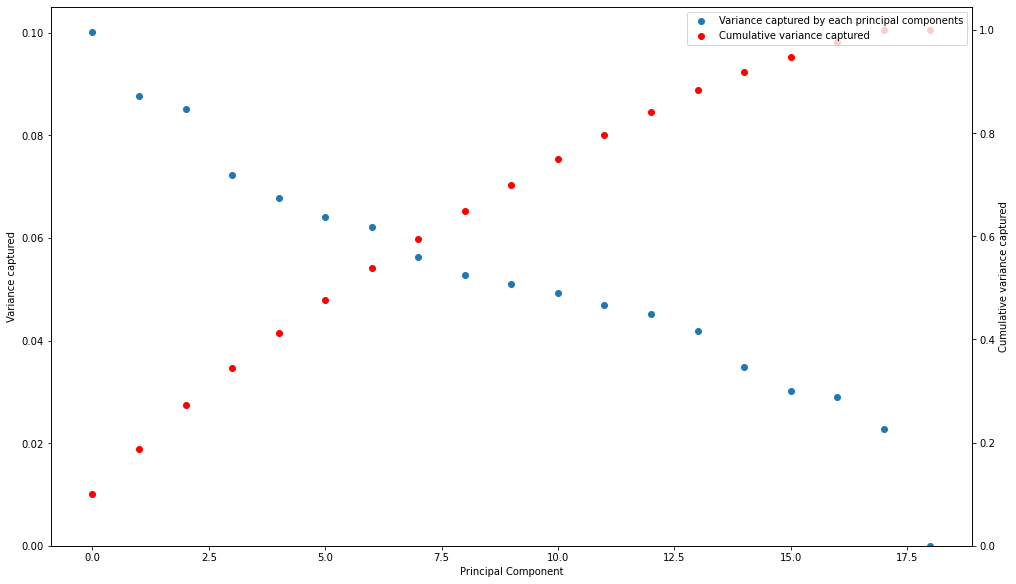

In [197]:
### Assess the amount of variance captured by each principal components
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize = (14,8), constrained_layout=True)

# Plot the amount of variance captured by each principal components
sc1 = ax.scatter(range(n_actors), explained_variance, label='Variance captured by each principal components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance captured')
ax.set_ylim(ymin=0)

# Plot the cumulative amount of variance captured on second y-axis
ax2 = ax.twinx()  # Create second y-axis
sc2 = ax2.scatter(range(n_actors), cumulative_variance, color='red', label='Cumulative variance captured')
ax2.set_ylabel('Cumulative variance captured')
ax2.set_ylim(ymin=0)

plt.legend(handles = [sc1, sc2], loc=1)
plt.show()

### Visualized PCA - Socio-Symbolic Constellations

In [198]:
### Identify the types that loads most on each principal dimension

# Determine how many words to plot in each direction
n_terms = 15

# Identify the indices that sorts the two first components
PCa_load_sidx = L[:,0].argsort()
PCb_load_sidx = L[:,1].argsort()

# Find the terms that load most on the first principal component
PCa_plot_idx = np.concatenate((PCa_load_sidx[:n_terms], PCa_load_sidx[-n_terms:]))

# Identify remaining indices
remain_idx = np.array([idx for idx in PCb_load_sidx if idx not in PCa_plot_idx])

# Find the remaining terms that load most on the second principal component
PCb_plot_idx = np.concatenate((remain_idx[:n_terms], remain_idx[-n_terms:]))

# Combine the indices
PC_plot_idx = np.unique(np.concatenate((PCa_plot_idx, PCb_plot_idx)))

# Get the term names
PC_plot_names = type_names[assoc_idx][PC_plot_idx]

# Get the term loadings
PC_plot_load = L[PC_plot_idx,:]

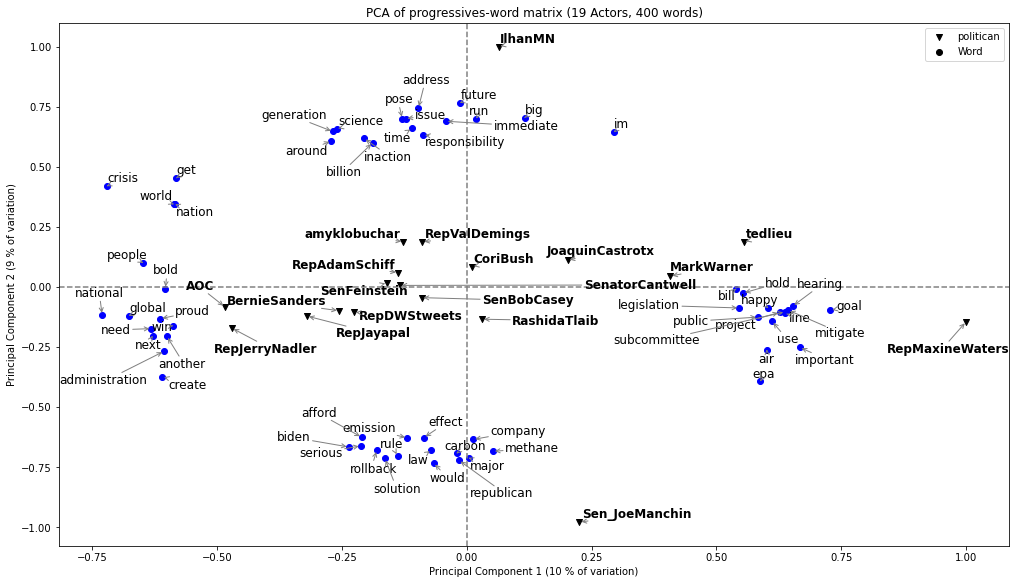

In [199]:
### Plot the socio-symbolic constellation
from adjustText import adjust_text
fig, ax = plt.subplots(1,1, figsize = (14,8), constrained_layout=True)

# Title and label text 
ax.set_title('PCA of progressives-word matrix ({} Actors, {} words)'.format(standardized_actor2type_frequency.shape[0],
                                                                 standardized_actor2type_frequency.shape[1],
                                                                 fontsize = 20,fontweight='bold'))
ax.set_xlabel('Principal Component 1 ({:0.0f} % of variation)'.format(100*pca.explained_variance_ratio_[0], fontsize = 15))
ax.set_ylabel('Principal Component 2 ({:0.0f} % of variation)'.format(100*pca.explained_variance_ratio_[1], fontsize = 15))

# Grid to mark zero loading             
ax.axvline(x=0, c='grey', linestyle='--')
ax.axhline(y=0, c='grey', linestyle='--')
       
# Plot standardized principal component scores
ax.scatter(scaled_PC[:,0], scaled_PC[:,1], marker = 'v', label='politican', c='black')

# Plot word loadings
ax.scatter(PC_plot_load[:,0], PC_plot_load[:, 1], marker = 'o', label='Word', c='blue')

# Annotate the plot
texts = []
for x, y, txt in zip(scaled_PC[:,0], scaled_PC[:,1], actor_names):
    texts.append(plt.text(x, y, txt, size=12, weight='bold'))


for x, y, txt in zip(PC_plot_load[:,0], PC_plot_load[:,1], PC_plot_names):
    texts.append(plt.text(x, y, txt, size=12))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow

# Set legend to black
plt.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
             
plt.show()
#plt.savefig('pca_exam')